In [1]:
import math
import os
os.sys.path.append("../")
import re
from typing import Union

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import spatial, stats
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from tqdm import tqdm 

import graph
import utils

In [34]:
import MSDiversity as msd

/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/spaghetti/network.py:40: FutureWarning: The next major release of pysal/spaghetti (2.0.0) will drop support for all ``libpysal.cg`` geometries. This change is a first step in refactoring ``spaghetti`` that is expected to result in dramatically reduced runtimes for network instantiation and operations. Users currently requiring network and point pattern input as ``libpysal.cg`` geometries should prepare for this simply by converting to ``shapely`` geometries.
  warnings.warn(dep_msg, FutureWarning, stacklevel=1)


In [2]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['svg.fonttype'] = 'none'  # To keep text as text in SVGs

In [3]:
data_dir = '../../../../tonsil/'

# Load data
# combine data os path
protein = pd.read_csv(os.path.join(data_dir, 'tonsil_codex.csv')) # ~178,000 codex cells

In [4]:
protein

Unnamed: 0.1  Unnamed: 0  cellLabelInImage  cellSize     HOECHST1  \
0                  0        8142                 1        51  6267.294118   
1                  1        8143                 2        53  6805.830189   
2                  2        8144                 3        57  4889.789474   
3                  3        8147                 6        56  4450.660714   
4                  4        8148                 7        79  8951.000000   
...              ...         ...               ...       ...          ...   
178914        178914      307664              4081        46  4188.065217   
178915        178915      307665              4082        65  4169.923077   
178916        178916      307666              4083        75  9355.746667   
178917        178917      307667              4084        77  7284.675325   
178918        178918      307669              4086        38  9039.973684   

            CD38      CD19      CD31  Vimentin      CD22  ...     CD104  \
0       0.143310  0.614983  0.016350  0.299605  1.000000  ...  0.025635   
1       0.069681  1.000000  0.153656  1.000000  0.718178  ...  0.073011   
2       0.438127  1.000000  0.044091  0.273363  0.443502  ...  0.286851   
3       0.000000  1.000000  0.050185  0.274332  1.000000  ...  0.028937   
4       0.114900  0.412287  0.039873  0.418782  0.769603  ...  0.018779   
...          ...       ...       ...       ...       ...  ...       ...   
178914  0.000000  0.516711  0.079410  0.000000  0.904165  ...  0.010496   
178915  0.210978  0.034039  0.010116  0.024256  0.000000  ...  0.032785   
178916  0.086992  0.020658  0.005740  0.334716  0.000000  ...  0.077727   
178917  0.143877  0.785678  0.138733  0.184268  1.000000  ...  0.079336   
178918  0.039704  0.412296  0.024666  0.101550  0.912263  ...  0.051244   

           CD273  FAPalpha  Ecadherin            PointNum  cluster.term  \
0       0.026118  0.214350   0.178581  reg001_X02_Y07_Z09   B-CD22-CD40   
1       1.000000  0.338075   0.342726  reg001_X02_Y07_Z09   B-CD22-CD40   
2       1.000000  0.789193   0.340269  reg001_X02_Y07_Z09        B-Ki67   
3       0.000000  0.166796   0.082396  reg001_X02_Y07_Z09   B-CD22-CD40   
4       0.000000  0.067358   0.166426  reg001_X02_Y07_Z09   B-CD22-CD40   
...          ...       ...        ...                 ...           ...   
178914  0.000000  0.000000   0.000000  reg001_X08_Y15_Z06   B-CD22-CD40   
178915  0.104098  0.257564   0.106543  reg001_X08_Y15_Z06         CD4 T   
178916  0.280892  0.638970   0.230460  reg001_X08_Y15_Z06         CD4 T   
178917  0.120146  0.439836   0.316185  reg001_X08_Y15_Z06   B-CD22-CD40   
178918  0.021559  0.065932   0.060742  reg001_X08_Y15_Z06   B-CD22-CD40   

        seurat_res1.0   centroid_x   centroid_y  step  
0                   8     1.725490   510.843137     0  
1                   7     1.754717   881.490566     0  
2                   6     1.964912  1287.526316     0  
3                   0     1.910714   660.875000     0  
4                   4     2.291139   851.860759     0  
...               ...          ...          ...   ...  
178914              0  9069.152174  8730.326087     0  
178915              1  9069.292308  8789.384615     0  
178916              1  9068.853333  9216.053333     0  
178917              0  9068.948052  8273.857143    13  
178918              4  9069.526316  9071.394737     0  

[178919 rows x 57 columns]

In [5]:
# protein expression in protein
protein_features = ['CD38', 'CD19', 'CD31', 'Vimentin', 'CD22', 'Ki67', 'CD8',
       'CD90', 'CD123', 'CD15', 'CD3', 'CD152', 'CD21', 'cytokeratin', 'CD2',
       'CD66', 'collagen IV', 'CD81', 'HLA-DR', 'CD57', 'CD4', 'CD7', 'CD278',
       'podoplanin', 'CD45RA', 'CD34', 'CD54', 'CD9', 'IGM', 'CD117', 'CD56',
       'CD279', 'CD45', 'CD49f', 'CD5', 'CD16', 'CD63', 'CD11b', 'CD1c',
       'CD40', 'CD274', 'CD27', 'CD104', 'CD273', 'FAPalpha', 'Ecadherin']
protein_exp = protein[protein_features]

# Cell-type Composition Clustering

In [6]:
# Get neighborhood composition
ks = 20
locations = protein[['centroid_x', 'centroid_y']].values
feature_labels = protein['cluster.term'].values
spatial_knn_indices = graph.get_spatial_knn_indices(locations=locations, n_neighbors=ks, method='kd_tree') 
cell_nbhd = utils.get_neighborhood_composition(knn_indices=spatial_knn_indices, labels=feature_labels)
#print(cell_nbhd)
#print(cell_nbhd.shape) # ~178,000 neighbors x 6 cell typs percentage

In [7]:
cell_nbhd

array([[0.9 , 0.  , 0.1 , 0.  , 0.  , 0.  ],
       [0.95, 0.  , 0.  , 0.05, 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  ],
       ...,
       [0.75, 0.  , 0.2 , 0.05, 0.  , 0.  ],
       [1.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.8 , 0.  , 0.1 , 0.1 , 0.  , 0.  ]])

In [8]:
# k-means clustering on cell_nbhd
n_cluster = 10
kmeans = KMeans(n_clusters=n_cluster, random_state=0).fit(cell_nbhd)
#print(kmeans.labels_)
protein['cluster_composition'] = kmeans.labels_.astype(str)

/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [9]:
cell_type_order = sorted(protein['cluster.term'].unique())

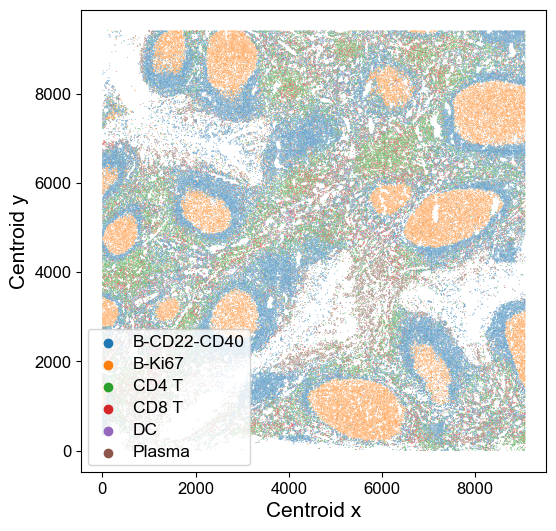

In [153]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=protein, x="centroid_x", y="centroid_y", 
                hue="cluster.term", s = 0.3, rasterized=True,
               hue_order = cell_type_order)#,
               #palette="muted")
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Centroid x", fontsize=15)
plt.ylabel("Centroid y", fontsize=15)

legend = plt.legend(title='', loc='lower left')
legend.get_title().set_fontsize('0') 
for label in legend.get_texts():
    label.set_fontsize(12.5)

#plt.savefig('../figures/tonsil/tonsil_celltype.png')
#plt.savefig('../figures/tonsil/tonsil_celltype.svg', dpi=300)
#plt.show()

In [10]:
order_clusters_composition = sorted(protein['cluster_composition'].unique())

In [ ]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=protein, x="centroid_x", y="centroid_y", hue="cluster_composition", 
                hue_order=order_clusters_composition, s = 0.3, rasterized=True)#,
               #palette="muted")

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Centroid x", fontsize=15)
plt.ylabel("Centroid y", fontsize=15)

legend = plt.legend(title='', loc='upper left')
legend.get_title().set_fontsize('0') 
for label in legend.get_texts():
    label.set_fontsize(12.5)

#plt.savefig('../figures/tonsil/tonsil_ct_composition.png')
#plt.savefig('../figures/tonsil/tonsil_ct_composition.svg', dpi=300)
#plt.show()

# Protein Clustering

In [29]:
avg_exp = utils.get_avg_expression_neighbors(protein_exp, spatial_knn_indices)
avg_exp_df = np.stack(avg_exp)

Computing avg expression: 100%|███████| 178919/178919 [00:28<00:00, 6258.86it/s]


In [30]:
# k-means clustering on avg_exp_df
n_cluster = 10
kmeans_protein = KMeans(n_clusters=n_cluster, random_state=0).fit(avg_exp_df)
protein['cluster_protein'] = kmeans_protein.labels_.astype(str)

/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [31]:
order_clusters_protein = sorted(protein['cluster_protein'].unique())

In [32]:
protein['cluster_protein_order'] = protein['cluster_protein']
index1 = protein[protein['cluster_protein_order'] == '1'].index
index2 = protein[protein['cluster_protein_order'] == '9'].index
protein.loc[index1, 'cluster_protein_order'] = '9'
protein.loc[index2, 'cluster_protein_order'] = '1'

index3 = protein[protein['cluster_protein_order'] == '7'].index
index4 = protein[protein['cluster_protein_order'] == '2'].index
protein.loc[index3, 'cluster_protein_order'] = '2'
protein.loc[index4, 'cluster_protein_order'] = '7'

index5 = protein[protein['cluster_protein_order'] == '0'].index
index6 = protein[protein['cluster_protein_order'] == '5'].index
protein.loc[index5, 'cluster_protein_order'] = '5'
protein.loc[index6, 'cluster_protein_order'] = '0'

index7 = protein[protein['cluster_protein_order'] == '2'].index
index8 = protein[protein['cluster_protein_order'] == '9'].index
protein.loc[index7, 'cluster_protein_order'] = '9'
protein.loc[index8, 'cluster_protein_order'] = '2'

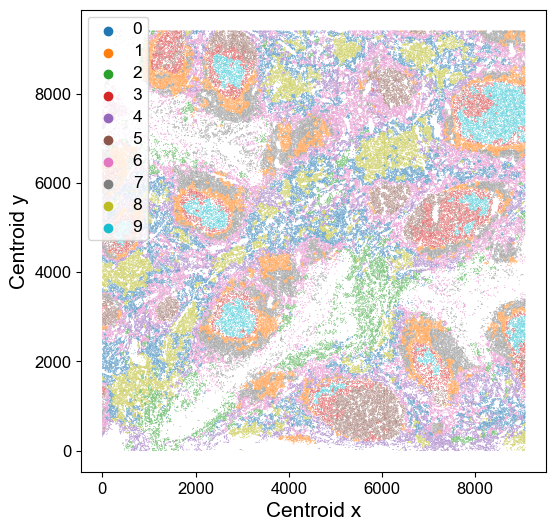

In [88]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=protein, x="centroid_x", y="centroid_y", hue="cluster_protein", 
                hue_order=order_clusters_protein, s=0.3, rasterized=True)#,
                #palette="bright")

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Centroid x", fontsize=15)
plt.ylabel("Centroid y", fontsize=15)

legend = plt.legend(title='', loc='upper left')
legend.get_title().set_fontsize('0') 
for label in legend.get_texts():
    label.set_fontsize(12.5)

#plt.savefig('../figures/tonsil/tonsil_avgprotein.png')
#plt.savefig('../figures/tonsil/tonsil_avgprotein.svg', dpi=300)
#plt.show()

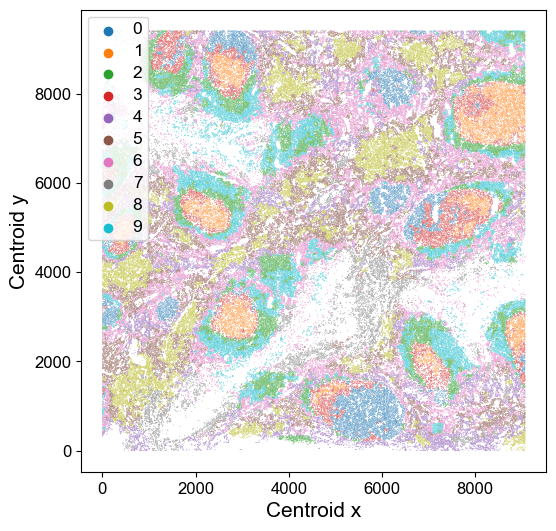

In [34]:
plt.figure(figsize=(6, 6))
scatterplot = sns.scatterplot(data=protein, x="centroid_x", y="centroid_y", hue="cluster_protein_order", 
                hue_order=order_clusters_protein, s=0.3, rasterized=True)#,
                #palette="bright")

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Centroid x", fontsize=15)
plt.ylabel("Centroid y", fontsize=15)

legend = plt.legend(title='', loc='upper left')
legend.get_title().set_fontsize('0') 
for label in legend.get_texts():
    label.set_fontsize(12.5)

plt.savefig('NEW_figures/tonsil_avgprotein_order.png')
plt.show()

In [37]:
import matplotlib
handles, labels = scatterplot.get_legend_handles_labels()

def rgba_to_hex(rgba):
    # Ensure alpha is ignored and convert RGBA to hexadecimal
    return matplotlib.colors.to_hex(rgba)

# Extract the colors from the plot
for handle, label in zip(handles, labels):
    if hasattr(handle, 'get_facecolor'):
        rgba_color = handle.get_facecolor()[0]  # Get the RGBA color
        hex_color = rgba_to_hex(rgba_color)  # Convert RGBA to hex
        print(f"Cluster Label: {label}, Color (Hex): {hex_color}")

Cluster Label: 0, Color (Hex): #1f77b4
Cluster Label: 1, Color (Hex): #ff7f0e
Cluster Label: 2, Color (Hex): #2ca02c
Cluster Label: 3, Color (Hex): #d62728
Cluster Label: 4, Color (Hex): #9467bd
Cluster Label: 5, Color (Hex): #8c564b
Cluster Label: 6, Color (Hex): #e377c2
Cluster Label: 7, Color (Hex): #7f7f7f
Cluster Label: 8, Color (Hex): #bcbd22
Cluster Label: 9, Color (Hex): #17becf


# RNA clustering

In [10]:
df_rna_match = pd.read_csv('../multiomics_fusion/NEW_results/tonsil_codex_rna_new_subsample_1.csv')
df_rna_match.columns = ['rna', 'protein', 'score']

In [11]:
from scipy.io import mmread

In [45]:
#rna = pd.read_csv('../../../../tonsil/Tonsil_HCA/data/tonsil_100k_5khvg_counts.csv')
#rna_names = rna.columns.to_numpy()

In [10]:
#from scipy.sparse import csr_matrix
#rna_csr = csr_matrix(rna.values)

#rna_adata = ad.AnnData(
#    rna_csr.tocsr(), dtype=np.float32)
#rna_adata.var_names = rna_names

In [12]:
rna_adata = ad.read_h5ad('../multiomics_fusion/NEW_results/rna_adata_subsample_1.h5ad')

In [13]:
import scanpy as sc

In [14]:
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
sc.pp.highly_variable_genes(rna_adata, n_top_genes=2000) #Try othe rvalues
rna_adata = rna_adata[:, rna_adata.var.highly_variable].copy()

In [15]:
rna_exp = rna_adata.X.toarray()

In [16]:
rna_matched = []
for i in tqdm(range(protein.shape[0]), total=protein.shape[0], desc='Assigning rna expression'):
    if i in df_rna_match['protein'].values:
        rna_idx = df_rna_match[df_rna_match['protein'] == i]['rna']
        rna_exp_each = rna_exp[rna_idx][0]
        rna_matched.append(rna_exp_each)
    else:
        rna_matched.append(np.array([0]*rna_exp.shape[1]))

Assigning rna expression: 100%|███████| 178919/178919 [00:29<00:00, 6075.44it/s]


In [17]:
rna_matched_protein_order = np.stack(rna_matched)

In [18]:
rna_matched_df = pd.DataFrame(rna_matched_protein_order)

# calculate the average rna expression based on rna_matched_protein_order for each cluster
avg_exp_rna = utils.get_avg_expression_neighbors(rna_matched_df, spatial_knn_indices)
avg_exp_rna_df = np.stack(avg_exp_rna)

Computing avg expression: 100%|███████| 178919/178919 [00:42<00:00, 4170.72it/s]


In [19]:
n_cluster = 10
kmeans_rna = KMeans(n_clusters=n_cluster, random_state=0).fit(avg_exp_rna_df)
protein['cluster_rna'] = kmeans_rna.labels_.astype(str)

/Users/daisyding/opt/miniconda3/envs/omics/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [20]:
order_clusters_rna = sorted(protein['cluster_rna'].unique())

In [21]:
protein['cluster_rna_order'] = protein['cluster_rna']

In [22]:
index1 = protein[protein['cluster_rna_order'] == '1'].index
index2 = protein[protein['cluster_rna_order'] == '9'].index

protein.loc[index1, 'cluster_rna_order'] = '9' 
protein.loc[index2, 'cluster_rna_order'] = '1' 

In [23]:
index3 = protein[protein['cluster_rna_order'] == '5'].index
index4 = protein[protein['cluster_rna_order'] == '3'].index

protein.loc[index3, 'cluster_rna_order'] = '3' 
protein.loc[index4, 'cluster_rna_order'] = '5' 

In [24]:
index5 = protein[protein['cluster_rna_order'] == '0'].index
index6 = protein[protein['cluster_rna_order'] == '4'].index

protein.loc[index5, 'cluster_rna_order'] = '4' 
protein.loc[index6, 'cluster_rna_order'] = '0' 

In [25]:
index7 = protein[protein['cluster_rna_order'] == '7'].index
index8 = protein[protein['cluster_rna_order'] == '8'].index

protein.loc[index7, 'cluster_rna_order'] = '8' 
protein.loc[index8, 'cluster_rna_order'] = '7' 

In [26]:
index9 = protein[protein['cluster_rna_order'] == '6'].index
index10 = protein[protein['cluster_rna_order'] == '9'].index

protein.loc[index9, 'cluster_rna_order'] = '9' 
protein.loc[index10, 'cluster_rna_order'] = '6' 

In [27]:
index11 = protein[protein['cluster_rna_order'] == '2'].index
index12 = protein[protein['cluster_rna_order'] == '5'].index

protein.loc[index11, 'cluster_rna_order'] = '5' 
protein.loc[index12, 'cluster_rna_order'] = '2' 

In [28]:
index12 = protein[protein['cluster_rna_order'] == '4'].index
index13 = protein[protein['cluster_rna_order'] == '7'].index

protein.loc[index12, 'cluster_rna_order'] = '7' 
protein.loc[index13, 'cluster_rna_order'] = '4' 

In [29]:
index14 = protein[protein['cluster_rna_order'] == '4'].index
index15 = protein[protein['cluster_rna_order'] == '9'].index

protein.loc[index14, 'cluster_rna_order'] = '9' 
protein.loc[index15, 'cluster_rna_order'] = '4' 

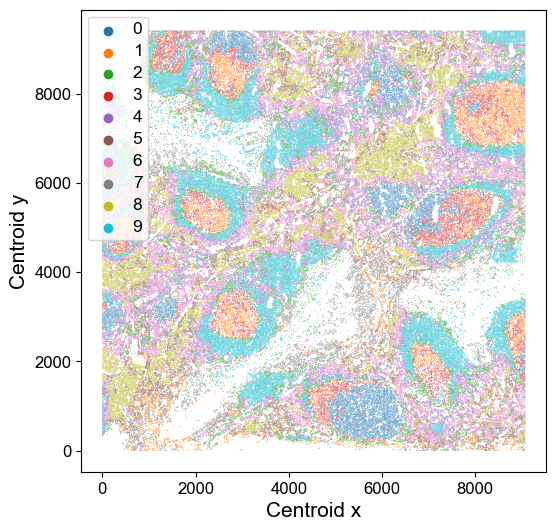

In [80]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=protein, x="centroid_x", y="centroid_y", hue="cluster_rna_order", 
                hue_order=order_clusters_rna, s=0.3, rasterized=True)#,
                #palette="bright")

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Centroid x", fontsize=15)
plt.ylabel("Centroid y", fontsize=15)

legend = plt.legend(title='', loc='upper left')
legend.get_title().set_fontsize('0') 
for label in legend.get_texts():
    label.set_fontsize(12.5)

plt.savefig('./NEW_figures/tonsil_avgrna_order_rnaseq_second_subsample_1.png')
#plt.savefig('../figures/tonsil/tonsil_avgrna_order.svg', dpi=300)
plt.show()

In [31]:
protein_region = protein
protein_patch = protein_region[
                (protein_region["centroid_x"] >= 1500) &#example_patch[0]) &
                (protein_region["centroid_x"] < 3700) & #example_patch[2]) &
                (protein_region["centroid_y"] >= 7200) &#example_patch[1]) &
                (protein_region["centroid_y"] < 9400) #example_patch[3])
            ]

In [ ]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=protein_patch, x="centroid_x", y="centroid_y", 
                hue="cluster_rna_order", s = 6, rasterized=True,
               hue_order=order_clusters_rna)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Centroid x", fontsize=15)
plt.ylabel("Centroid y", fontsize=15)

legend = plt.legend(title='', loc='lower left')
legend.get_title().set_fontsize('0') 
for label in legend.get_texts():
    label.set_fontsize(12.5)

plt.savefig('NEW_figures/tonsil_avgrna_order_rnaseq_second_subsample_1_patch.png')
plt.show()

In [35]:
protein_patch

Unnamed: 0.1  Unnamed: 0  cellLabelInImage  cellSize      HOECHST1  \
128656        128656      234226              1553       191   1326.434555   
128658        128658      234230              1557       467   4072.197002   
128659        128659      234233              1560       452   6038.161504   
128664        128664      234241              1568       436   5840.577982   
128665        128665      234254              1581       213   4956.784038   
...              ...         ...               ...       ...           ...   
161539        161539      285145              2921       384   7368.507812   
161540        161540      285146              2922       266   7626.443609   
161541        161541      285147              2923       239   9716.702929   
161542        161542      285148              2924       241   7921.468880   
161543        161543      285149              2925       219  11529.287671   

            CD38      CD19      CD31  Vimentin      CD22  ...  Ecadherin  \
128656  0.334824  0.137285  0.197385  0.454728  0.118722  ...   0.140828   
128658  0.002396  0.089442  0.008054  0.301954  0.097582  ...   0.129463   
128659  0.058798  0.494963  0.074976  0.468305  0.392916  ...   0.363522   
128664  0.160169  0.545469  0.165820  0.223527  0.622284  ...   0.217911   
128665  0.006102  0.550863  0.091538  0.224367  0.538929  ...   0.062187   
...          ...       ...       ...       ...       ...  ...        ...   
161539  0.091901  0.275581  0.083234  0.109278  0.376310  ...   0.136393   
161540  0.042391  0.035136  0.030737  0.226721  0.032966  ...   0.264925   
161541  0.116622  0.555960  0.040813  0.239110  0.228902  ...   0.248462   
161542  0.000000  0.038173  0.425873  0.213080  0.024161  ...   0.183223   
161543  0.163399  0.341175  0.100440  0.097193  0.235201  ...   0.322827   

                  PointNum  cluster.term  seurat_res1.0   centroid_x  \
128656  reg001_X07_Y08_Z04         CD4 T              1  1500.308901   
128658  reg001_X07_Y08_Z04         CD4 T              1  1502.783726   
128659  reg001_X07_Y08_Z04   B-CD22-CD40              7  1502.130531   
128664  reg001_X07_Y08_Z04   B-CD22-CD40              0  1505.055046   
128665  reg001_X07_Y08_Z04   B-CD22-CD40              4  1510.643192   
...                    ...           ...            ...          ...   
161539  reg001_X08_Y10_Z04   B-CD22-CD40              8  3699.291667   
161540  reg001_X08_Y10_Z04         CD4 T              1  3699.364662   
161541  reg001_X08_Y10_Z04         CD4 T              1  3699.451883   
161542  reg001_X08_Y10_Z04            DC             20  3699.302905   
161543  reg001_X08_Y10_Z04         CD4 T              1  3699.890411   

         centroid_y  step  cluster_composition  cluster_rna  cluster_rna_order  
128656  7941.643979     0                    9            3                  2  
128658  8005.434690     0                    9            8                  9  
128659  7973.884956     0                    9            8                  9  
128664  8026.708716     0                    9            8                  9  
128665  7955.746479     0                    9            6                  4  
...             ...   ...                  ...          ...                ...  
161539  9343.221354     0                    7            6                  4  
161540  8372.932331     0                    8            7                  8  
161541  8976.422594     0                    3            1                  6  
161542  9014.493776     0                    3            3                  2  
161543  9114.246575     0                    2            2                  5  

[11517 rows x 60 columns]

In [43]:
count_array = protein_patch['cluster_rna_order'].value_counts()
N = np.sum(count_array)
probabilities = count_array / N
entropy = -np.sum(probabilities * np.log2(probabilities))
entropy

2.9876785833332034

# Patch Visualization

In [82]:
import matplotlib.patches as patches

In [83]:
protein_region = protein.loc[protein['reg'] == '1',:]
patches_coordinates = msd.generate_patches(protein_region,
                                           'reg',
                                           '1', 
                                           scaling_factor=4., 
                                           spatial_key=['centroid_x','centroid_y'])

In [87]:
patch_id = 9 # patch id for visualisation
example_patch =  patches_coordinates[patch_id]
custom_patch = [(1500,7200,3700,9400)]
print(custom_patch)
protein_patch = protein_region[
                (protein_region["centroid_x"] >= custom_patch[0][0]) &#example_patch[0]) &
                (protein_region["centroid_x"] < custom_patch[0][2]) & #example_patch[2]) &
                (protein_region["centroid_y"] >= custom_patch[0][1]) &#example_patch[1]) &
                (protein_region["centroid_y"] < custom_patch[0][3]) #example_patch[3])
            ]

[(1500, 7200, 3700, 9400)]


In [49]:
patch_id = 9 # patch id for visualisation
example_patch =  patches_coordinates[patch_id]
print(example_patch)
protein_patch = protein_region[
                (protein_region["centroid_x"] >= 1500) &#example_patch[0]) &
                (protein_region["centroid_x"] < 3700) & #example_patch[2]) &
                (protein_region["centroid_y"] >= 7200) &#example_patch[1]) &
                (protein_region["centroid_y"] < 9400) #example_patch[3])
            ]

(2268.348847926267, 4703.754838709678, 4535.469124423962, 7054.732258064516)


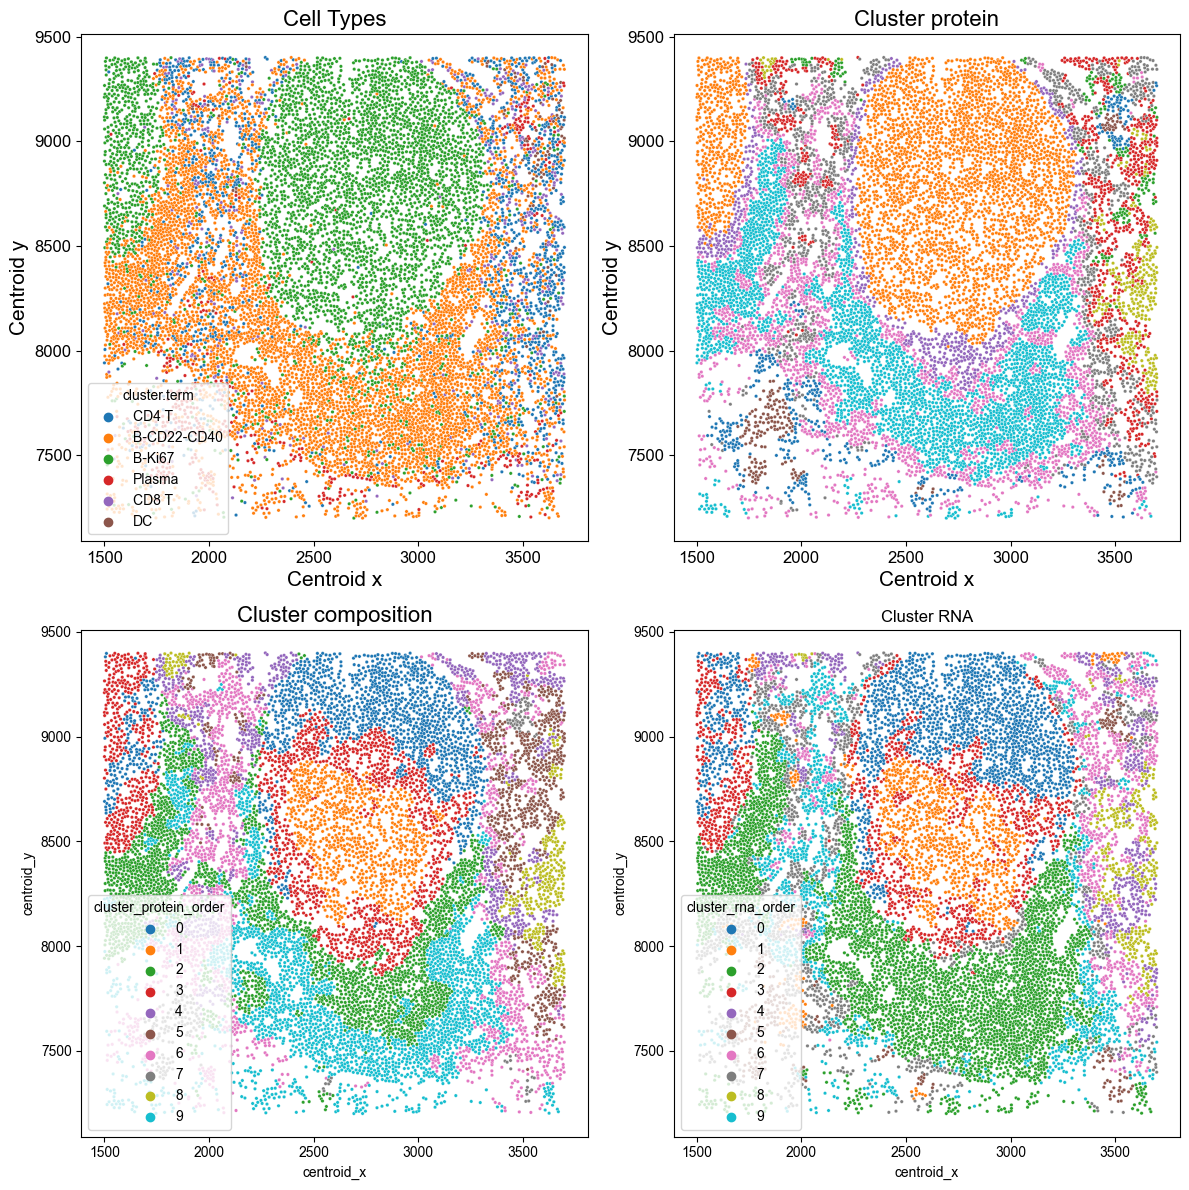

In [147]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))  # Adjusted for 2x2 subplots and figsize

sns.scatterplot(data=protein_patch, 
                x="centroid_x", 
                y="centroid_y", 
                hue="cluster.term", 
                s=6, 
                ax=axes[0, 0], 
                rasterized=True,
                legend=True)
axes[0, 0].set_title('Cell Types', fontsize=16)
axes[0, 0].tick_params(axis='x', labelsize=12)
axes[0, 0].tick_params(axis='y', labelsize=12)

axes[0, 0].set_xlabel("Centroid x", fontsize=15)
axes[0, 0].set_ylabel("Centroid y", fontsize=15)

sns.scatterplot(data=protein_patch, 
                x="centroid_x", 
                y="centroid_y", 
                hue="cluster_protein_order", 
                hue_order=order_clusters_protein,
                s=6, 
                ax=axes[1, 0], 
                rasterized=True,
                legend=True)
axes[0, 1].set_title('Cluster protein', fontsize=16)
axes[0, 1].tick_params(axis='x', labelsize=12)
axes[0, 1].tick_params(axis='y', labelsize=12)

axes[0, 1].set_xlabel("Centroid x", fontsize=15)
axes[0, 1].set_ylabel("Centroid y", fontsize=15)


sns.scatterplot(data=protein_patch, 
                x="centroid_x", 
                y="centroid_y", 
                hue="cluster_composition", 
                hue_order=order_clusters_composition, 
                s=6, 
                legend=False,
                rasterized=True,
                ax=axes[0, 1])
axes[1, 0].set_title('Cluster composition', fontsize=16)


sns.scatterplot(data=protein_patch, 
                x="centroid_x", 
                y="centroid_y", 
                hue="cluster_rna_order", 
                hue_order=order_clusters_rna,
                s=6, 
                ax=axes[1, 1], 
                rasterized=True,
                legend=True)
axes[1, 1].set_title('Cluster RNA')

plt.tight_layout()
plt.savefig('../figures/tonsil/tonsil_patch_visualisation.png')
plt.savefig('../figures/tonsil/tonsil_patch_visualisation.svg', dpi=300)
plt.show()

In [125]:
cell_type_order = sorted(protein['cluster.term'].unique())

In [126]:
cell_type_order

['B-CD22-CD40', 'B-Ki67', 'CD4 T', 'CD8 T', 'DC', 'Plasma']

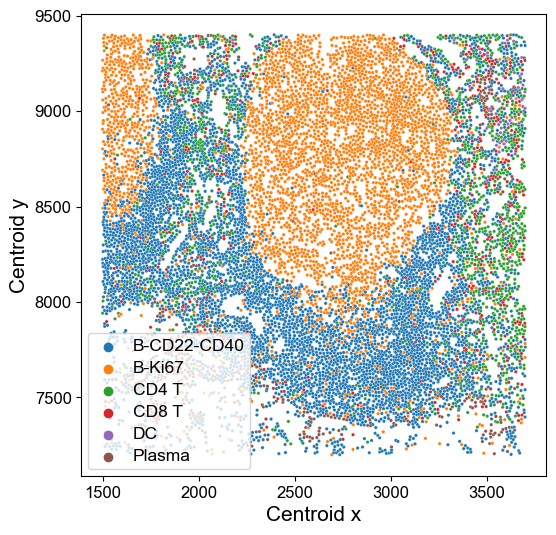

In [145]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=protein_patch, x="centroid_x", y="centroid_y", 
                hue="cluster.term", s = 6, rasterized=True,
               hue_order=cell_type_order)#,
               #palette="muted")
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Centroid x", fontsize=15)
plt.ylabel("Centroid y", fontsize=15)

legend = plt.legend(title='', loc='lower left')
legend.get_title().set_fontsize('0') 
for label in legend.get_texts():
    label.set_fontsize(12.5)

plt.savefig('../figures/tonsil/tonsil_celltype_patch.png')
plt.savefig('../figures/tonsil/tonsil_celltype_patch.svg', dpi=300)
plt.show()

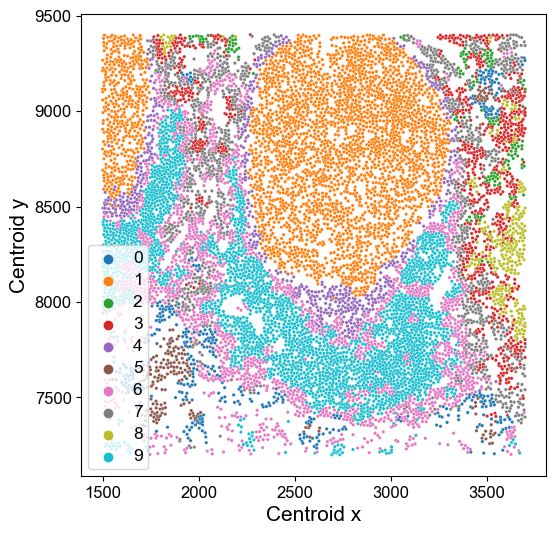

In [149]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=protein_patch, x="centroid_x", y="centroid_y", hue="cluster_composition", 
                hue_order=order_clusters_composition, s =6, rasterized=True)#,
               #palette="muted")

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Centroid x", fontsize=15)
plt.ylabel("Centroid y", fontsize=15)

legend = plt.legend(title='', loc='lower left')
legend.get_title().set_fontsize('0') 
for label in legend.get_texts():
    label.set_fontsize(12.5)

plt.savefig('../figures/tonsil/tonsil_ct_composition_patch.png')
plt.savefig('../figures/tonsil/tonsil_ct_composition_patch.svg', dpi=300)
plt.show()

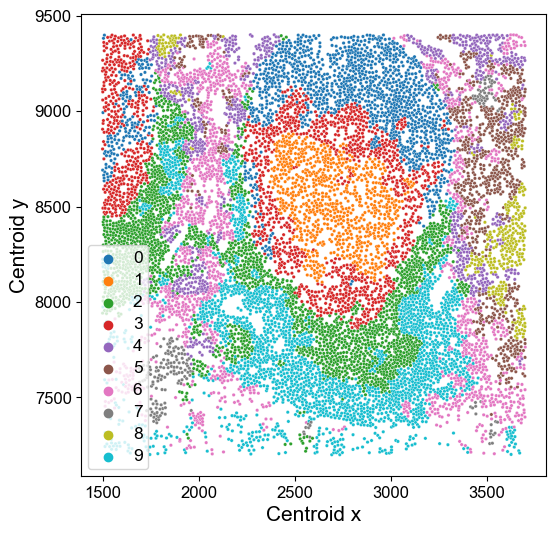

In [151]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=protein_patch, x="centroid_x", y="centroid_y", hue="cluster_protein_order", 
                hue_order=order_clusters_protein, s=6, rasterized=True)#,
                #palette="bright")

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Centroid x", fontsize=15)
plt.ylabel("Centroid y", fontsize=15)

legend = plt.legend(title='', loc='lower left')
legend.get_title().set_fontsize('0') 
for label in legend.get_texts():
    label.set_fontsize(12.5)

plt.savefig('../figures/tonsil/tonsil_avgprotein_order_patch.png')
plt.savefig('../figures/tonsil/tonsil_avgprotein_order_patch.svg', dpi=300)
plt.show()

# Emphasize Germinal Center Neighborhoods

In [76]:
default_palette = sns.color_palette()
for i, color in enumerate(default_palette[:10]):
    hex_color = "#{:02x}{:02x}{:02x}".format(int(color[0] * 255), int(color[1] * 255), int(color[2] * 255))
    print(f"Color {i}: {hex_color}")

Color 0: #1f77b4
Color 1: #ff7f0e
Color 2: #2ca02c
Color 3: #d62728
Color 4: #9467bd
Color 5: #8c564b
Color 6: #e377c2
Color 7: #7f7f7f
Color 8: #bcbd22
Color 9: #17becf


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


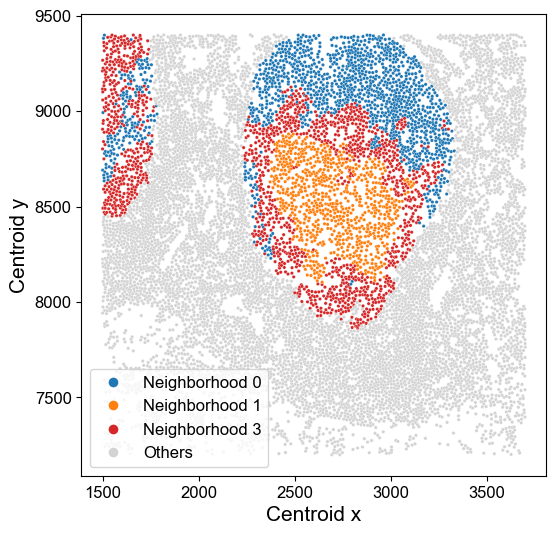

In [81]:
plt.figure(figsize=(6, 6))

protein_color_map = {'0': 'blue', '1': 'orange', '3': 'red'}
cluster_colors = [protein_color_map[val] if val in protein_color_map 
                  else 'gray' for val in np.array(protein_patch['cluster_protein_order'])]

#protein_color_map = {'0': 'blue', '1': 'orange', '3': 'red'}
#default_color = 'gray'
protein_color_map = {'0': '#1f77b4', '1': '#ff7f0e', '3': '#d62728'}
default_color = '#D3D3D3'

# Get cluster colors from the numpy array
cluster_colors = [protein_color_map.get(val, default_color) for val in np.array(protein_patch['cluster_protein_order'])]


sns.scatterplot(data=protein_patch, x="centroid_x", y="centroid_y", color=cluster_colors, #hue = cluster_colors,
                s=6, rasterized=True)

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Centroid x", fontsize=15)
plt.ylabel("Centroid y", fontsize=15)

legend = plt.legend(title='', loc='lower left')
legend.get_title().set_fontsize('0') 
for label in legend.get_texts():
    label.set_fontsize(12.5)
    
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=8, label=f'Neighborhood {val}')
           for val, color in protein_color_map.items()]
handles.append(plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=default_color, markersize=8, label='Others'))

plt.legend(handles=handles, title='', loc='lower left', fontsize=12)

plt.savefig('../figures/tonsil/tonsil_avgprotein_order_patch_contrast.png')
plt.savefig('../figures/tonsil/tonsil_avgprotein_order_patch_contrast.svg', dpi=300)
plt.show()

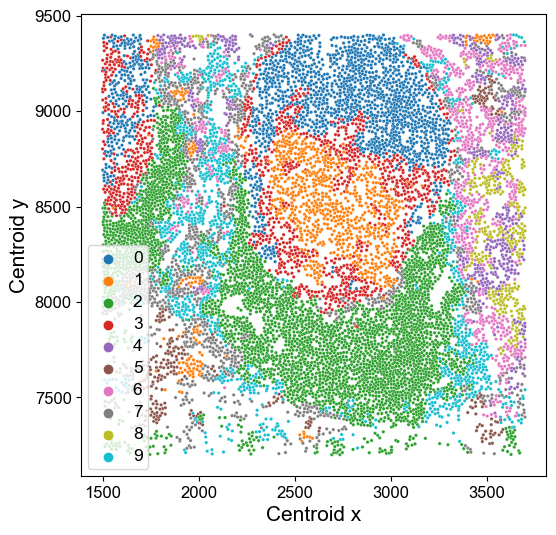

In [152]:
plt.figure(figsize=(6, 6))
sns.scatterplot(data=protein_patch, x="centroid_x", y="centroid_y", hue="cluster_rna_order", 
                hue_order=order_clusters_protein, s=6, rasterized=True)#,
                #palette="bright")

plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)

plt.xlabel("Centroid x", fontsize=15)
plt.ylabel("Centroid y", fontsize=15)

legend = plt.legend(title='', loc='lower left')
legend.get_title().set_fontsize('0') 
for label in legend.get_texts():
    label.set_fontsize(12.5)

plt.savefig('../figures/tonsil/tonsil_avgrna_order_patch.png')
plt.savefig('../figures/tonsil/tonsil_avgrna_order_patch.svg', dpi=300)
plt.show()

In [91]:
patch_indices, patch_comp = msd.calculate_heterogeneity_index(spatial_data=protein, 
                                                  library_key='reg', 
                                                  library_id='1', 
                                                  spatial_key=['centroid_x','centroid_y'], 
                                                  patches=patches_coordinates, 
                                                  cluster_key='cluster_protein', 
                                                  metric='Shannon Diversity', return_comp=True)


# Visualize the heterogeneity indices
grid = msd.diversity_heatmap(spatial_data=protein_region,
                             library_key='reg',
                             library_id='1',
                             spatial_key=['centroid_x','centroid_y'],
                             patches=patches_coordinates, 
                             heterogeneity_indices=patch_indices,
                             plot=False)
print(grid)
print(f"Patch {patch_id} has entropy of {grid.flatten()[patch_id]}")

0.000 per cent patches are empty
[[2.25353627 2.77976098 2.8851005  2.89876485]
 [2.63249571 2.87343339 2.53399064 2.39927029]
 [3.08985624 2.76256169 2.52906741 2.96203086]
 [2.57946624 3.11607316 2.52581721 2.95147478]]
Patch 9 has entropy of 2.762561687344395


In [92]:
protein.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'cellLabelInImage', 'cellSize',
       'HOECHST1', 'CD38', 'CD19', 'CD31', 'Vimentin', 'CD22', 'Ki67', 'CD8',
       'CD90', 'CD123', 'CD15', 'CD3', 'CD152', 'CD21', 'cytokeratin', 'CD2',
       'CD66', 'collagen IV', 'CD81', 'HLA-DR', 'CD57', 'CD4', 'CD7', 'CD278',
       'podoplanin', 'CD45RA', 'CD34', 'CD54', 'CD9', 'IGM', 'CD117', 'CD56',
       'CD279', 'CD45', 'CD49f', 'CD5', 'CD16', 'CD63', 'CD11b', 'CD1c',
       'CD40', 'CD274', 'CD27', 'CD104', 'CD273', 'FAPalpha', 'Ecadherin',
       'PointNum', 'cluster.term', 'seurat_res1.0', 'centroid_x', 'centroid_y',
       'step', 'reg', 'cluster_composition', 'cluster_protein',
       'cluster_protein_order', 'all_protein', 'composition', 'all_rna'],
      dtype='object')

In [93]:
patch_indices, patch_comp = msd.calculate_heterogeneity_index(spatial_data=protein, 
                                                  library_key='reg', 
                                                  library_id='1', 
                                                  spatial_key=['centroid_x','centroid_y'], 
                                                  patches=custom_patch, 
                                                  cluster_key='cluster.term', 
                                                  metric='Shannon Diversity', return_comp=True)


# Visualize the heterogeneity indices
grid = msd.diversity_heatmap(spatial_data=protein_region,
                             library_key='reg',
                             library_id='1',
                             spatial_key=['centroid_x','centroid_y'],
                             patches=custom_patch, 
                             heterogeneity_indices=patch_indices,
                             plot=False)
print(grid)

0.000 per cent patches are empty
[[1.80775838]]


In [98]:
patch_indices, patch_comp = msd.calculate_heterogeneity_index(spatial_data=protein, 
                                                  library_key='reg', 
                                                  library_id='1', 
                                                  spatial_key=['centroid_x','centroid_y'], 
                                                  patches=custom_patch, 
                                                  cluster_key='cluster_composition', 
                                                  metric='Shannon Diversity', return_comp=True)


# Visualize the heterogeneity indices
grid = msd.diversity_heatmap(spatial_data=protein_region,
                             library_key='reg',
                             library_id='1',
                             spatial_key=['centroid_x','centroid_y'],
                             patches=custom_patch, 
                             heterogeneity_indices=patch_indices,
                             plot=False)
print(grid)

0.000 per cent patches are empty
[[2.75719701]]


In [99]:
patch_indices, patch_comp = msd.calculate_heterogeneity_index(spatial_data=protein, 
                                                  library_key='reg', 
                                                  library_id='1', 
                                                  spatial_key=['centroid_x','centroid_y'], 
                                                  patches=custom_patch, 
                                                  cluster_key='cluster_protein', 
                                                  metric='Shannon Diversity', return_comp=True)


# Visualize the heterogeneity indices
grid = msd.diversity_heatmap(spatial_data=protein_region,
                             library_key='reg',
                             library_id='1',
                             spatial_key=['centroid_x','centroid_y'],
                             patches=custom_patch, 
                             heterogeneity_indices=patch_indices,
                             plot=False)
print(grid)

0.000 per cent patches are empty
[[3.06540868]]


In [104]:
patch_indices, patch_comp = msd.calculate_heterogeneity_index(spatial_data=protein, 
                                                  library_key='reg', 
                                                  library_id='1', 
                                                  spatial_key=['centroid_x','centroid_y'], 
                                                  patches=custom_patch, 
                                                  cluster_key='cluster_rna', 
                                                  metric='Shannon Diversity', return_comp=True)


# Visualize the heterogeneity indices
grid = msd.diversity_heatmap(spatial_data=protein_region,
                             library_key='reg',
                             library_id='1',
                             spatial_key=['centroid_x','centroid_y'],
                             patches=custom_patch, 
                             heterogeneity_indices=patch_indices,
                             plot=False)
print(grid)

0.000 per cent patches are empty
[[2.94927777]]


# Neighborhood Heatmap

In [24]:
# calculate the average protein expression for each cluster
protein['all_protein'] = protein_exp.values.tolist()
cluster_avg_exp = protein.groupby('cluster_protein_order')['all_protein'].apply(lambda x: np.mean(x.tolist(), axis=0))
cluster_avg_exp = np.stack(cluster_avg_exp.values)
cluster_avg_exp = pd.DataFrame(cluster_avg_exp, columns=protein_features)

In [25]:
# calculate the average cellular composition based on cell_nbhd for each cluster
protein['composition'] = cell_nbhd.tolist()
cluster_composition = protein.groupby('cluster_protein_order')['composition'].apply(lambda x: np.mean(x.tolist(), axis=0))
cluster_composition = np.stack(cluster_composition.values)
cluster_composition = pd.DataFrame(cluster_composition, columns=np.unique(list(feature_labels)))

In [26]:
# scale RNA expression to 0-1 to be comparable with protein expression
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
rna_matched_protein_order_scale = scaler.fit_transform(rna_matched_protein_order)
rna_matched_protein_order_scale = pd.DataFrame(rna_matched_protein_order_scale, columns=rna_adata.var_names)

In [27]:
# calculate the average RNA expression for each cluster
protein['all_rna'] = rna_matched_protein_order_scale.values.tolist()
cluster_avg_exp_rna = protein.groupby('cluster_protein_order')['all_rna'].apply(lambda x: np.mean(x.tolist(), axis=0))
cluster_avg_exp_rna = np.stack(cluster_avg_exp_rna.values)
cluster_avg_exp_rna = pd.DataFrame(cluster_avg_exp_rna, columns=rna_matched_protein_order_scale.columns)

In [28]:
# select highly variable RNAs
var_rna = cluster_avg_exp_rna.var()
top_variance_columns = var_rna.sort_values(ascending=False).head(50)
top_variance_column_names = top_variance_columns.index.tolist()
cluster_avg_exp_rna_variable = cluster_avg_exp_rna[top_variance_column_names]

In [29]:
cluster_avg_exp_rna_variable.shape

(10, 50)

In [30]:
comb_df = pd.concat([cluster_composition, cluster_avg_exp, cluster_avg_exp_rna_variable], axis=1)

In [31]:
comb_df.shape

(10, 102)

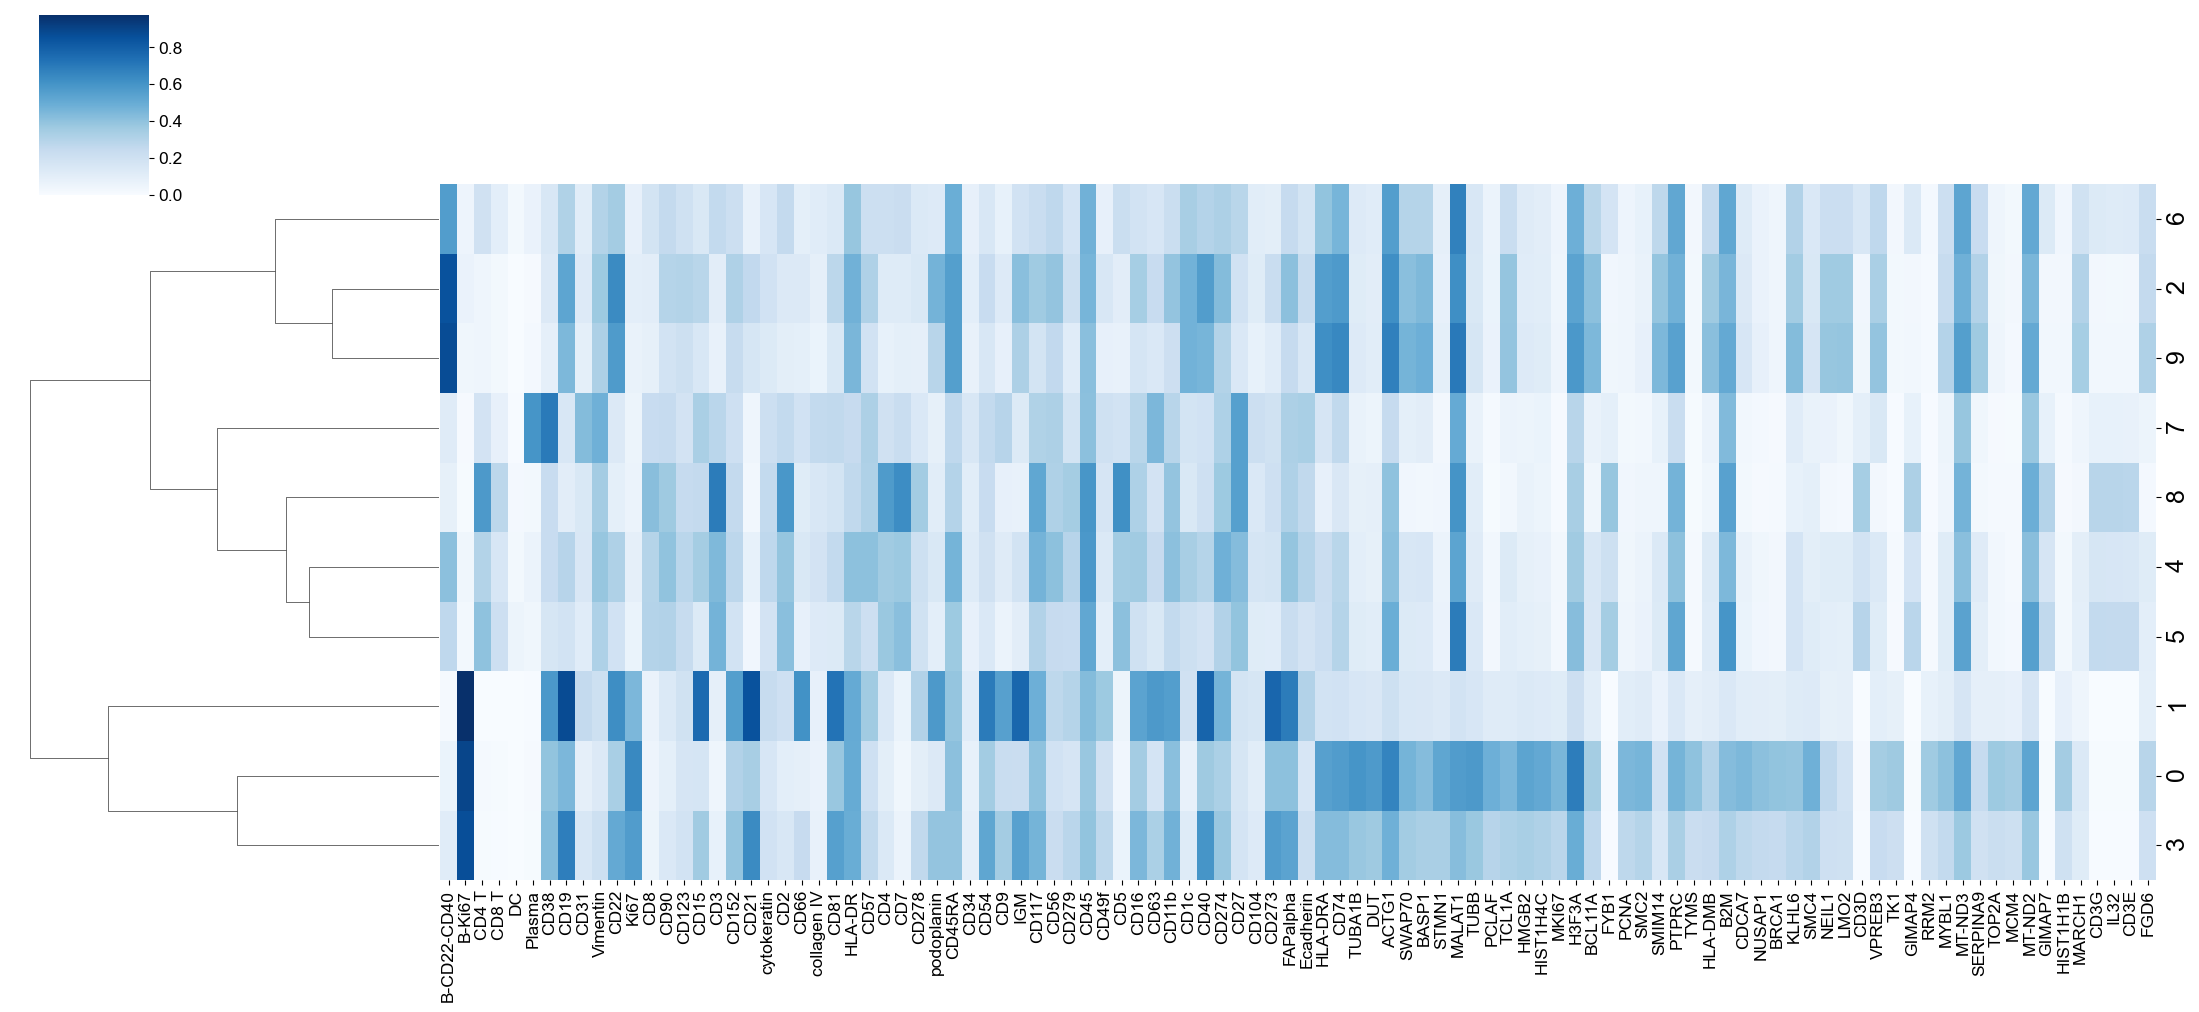

In [42]:
fg = sns.clustermap(comb_df, cmap='Blues', figsize=(22,10), 
                    row_cluster = True, 
                    col_cluster=False,
                    xticklabels=True, 
                    yticklabels=True)

fg.cax.yaxis.set_tick_params(labelsize=12.5)

fg.ax_heatmap.set_yticklabels(fg.ax_heatmap.get_yticklabels(), fontsize=18)
fg.ax_heatmap.set_xticklabels(fg.ax_heatmap.get_xticklabels(), fontsize=12.5);

plt.savefig('../figures/tonsil/tonsil_protein_neighborhood_heatmap.png')
plt.savefig('../figures/tonsil/tonsil_protein_neighborhood_heatmap.svg', dpi=300)
plt.show()